# Video Enhancement By Transfer Learning

In [3]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *
from torchvision.models import vgg16_bn

In [4]:
vid_dir = '/storage/VideoEnhancement/'
vid_name = 'input'
vid_path = vid_dir+vid_name+'.mp4'

In [5]:
name_output = 'vid-enh-with-mse'
name_mstn = 'vid-enh-try1'
name_ref = 'input-images'

# Video processing

Install ffmpeg using the indications in https://github.com/adaptlearning/adapt_authoring/wiki/Installing-FFmpeg
`
sudo add-apt-repository ppa:mc3man/trusty-media
sudo apt-get update  
sudo apt-get install ffmpeg  
sudo apt-get install frei0r-plugins
`

In [6]:
# # Uncomment the first time you run this notebook
# ! pip install moviepy
# ! pip install ffmpeg

In [7]:
from moviepy.editor import *

In [8]:
video = VideoFileClip(vid_path)

In [9]:
# #Uncomment when running for the first time this notebook in order to check that it works
# video.ipython_display()

In [10]:
fps = video.fps
fps

30.0

In [11]:
path_images = Path(vid_dir)/name_ref
path_images.mkdir(exist_ok=True)

Q: how can we accelerate this image writing process? It's currently the main bottleneck

In [12]:
# # Uncomment this when you run for the first time
# video.write_images_sequence(str(path_images)+'/frame%03d.png')

#  Fastai lesson 7 notebook

In [13]:
path = Path(vid_dir)
path_hr = path/'input-images' ## 512x288
path_lr = path/'lowres-72' ## 128x72
path_mr = path/'medres-144'## 256x144

In [14]:
il = ImageList.from_folder(path_hr)
il

ImageList (1636 items)
Image (3, 288, 512),Image (3, 288, 512),Image (3, 288, 512),Image (3, 288, 512),Image (3, 288, 512)
Path: /storage/VideoEnhancement/input-images

In [15]:
def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [16]:
# # create smaller image sets the first time this nb is run
# sets = [(path_lr, 72), (path_mr, 144)]
# for p,size in sets:
#     if not p.exists(): 
#         print(f"resizing to {size} into {p}")
#         parallel(partial(resize_one, path=p, size=size), il.items)

In [17]:
bs,size=16,256
arch = models.resnet34
src = ImageImageList.from_folder(path_mr).split_none()

In [18]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [19]:
data = get_data(bs,size)

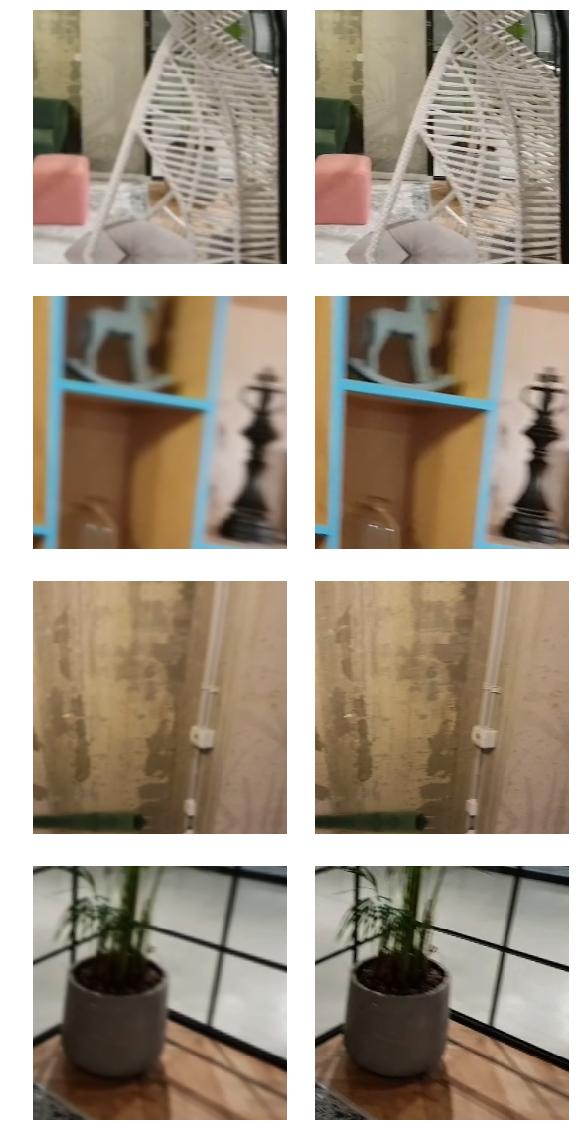

In [20]:
data.show_batch(ds_type=DatasetType.Train, rows=4)

## Feature loss

In [21]:
t = data.train_ds[0][1].data
t = torch.stack([t,t])

In [22]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [23]:
gram_matrix(t)

tensor([[[0.0895, 0.0797, 0.0688],
         [0.0797, 0.0727, 0.0637],
         [0.0688, 0.0637, 0.0570]],

        [[0.0895, 0.0797, 0.0688],
         [0.0797, 0.0727, 0.0637],
         [0.0688, 0.0637, 0.0570]]])

In [24]:
base_loss = F.l1_loss

In [25]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [26]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [27]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [28]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

# Training

## Define the model and load the pets one

In this section, we load the pet model obtained at the end of the [superres-notebook](https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson7-superres.ipynb). Please refer to [fastai course v3 lesson 7](https://forums.fast.ai/t/lesson-7-official-resources/32553) for more details.

In [29]:
mse_loss = MSELossFlat()

In [80]:
class LossPlusMSE(nn.Module):
    def __init__(self, loss1, alpha=1.0):
        super().__init__()
        self.loss1 = loss1
        self.mse_loss = MSELossFlat()
        self.alpha = alpha
        self.metric_names = loss1.metric_names + ['MSE']
    
    def forward(self, input, target):
        loss1_calc = self.loss1(input,target)
        mse_loss_calc = self.mse_loss(input,target)
        self.metrics = self.loss1.metrics
        mse_metrics = dict(zip(['MSE'], [mse_loss_calc]))
        (self.metrics).update(mse_metrics)
        return loss1_calc + self.alpha * torch.sqrt(mse_loss_calc)

In [95]:
unet_loss = LossPlusMSE(feat_loss, 10.0)

In [96]:
wd = 1e-4
learn = unet_learner(data, arch, wd=wd, loss_func=unet_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

In [97]:
path_regular_superres = Path('/storage/oxford-iiit-pet/small-96/models')
path_regular_superres.ls()

[PosixPath('/storage/oxford-iiit-pet/small-96/models/2a.pth'),
 PosixPath('/storage/oxford-iiit-pet/small-96/models/2b.pth'),
 PosixPath('/storage/oxford-iiit-pet/small-96/models/1a.pth'),
 PosixPath('/storage/oxford-iiit-pet/small-96/models/1b.pth'),
 PosixPath('/storage/oxford-iiit-pet/small-96/models/tmp.pth')]

In [98]:
learn.load((path_regular_superres/'2b').absolute());

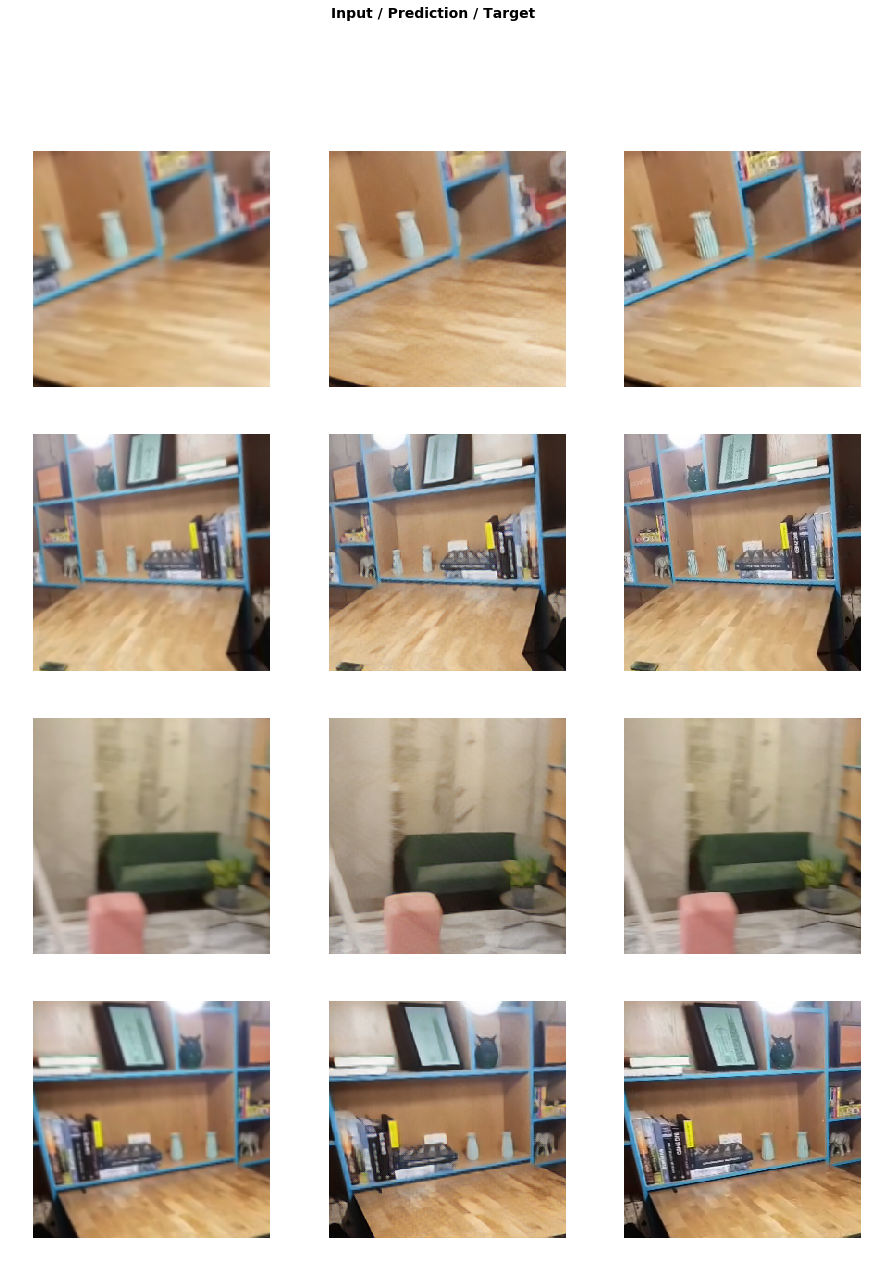

In [99]:
learn.show_results(ds_type= DatasetType.Train, rows=4, imgsize=5)

In [100]:
model_name_pets = 'enhance-pets'
learn.save(model_name_pets)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


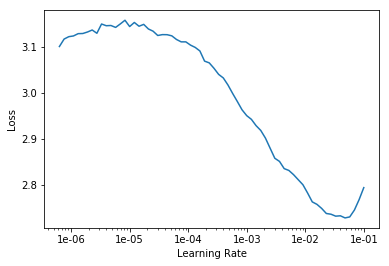

In [101]:
learn.lr_find(end_lr=10)
learn.recorder.plot()

In [102]:
lr = 5e-3

## Fast Training

In [103]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-6,lr))

In [104]:
learn.fit_one_cycle(2, slice(1e-6,lr))

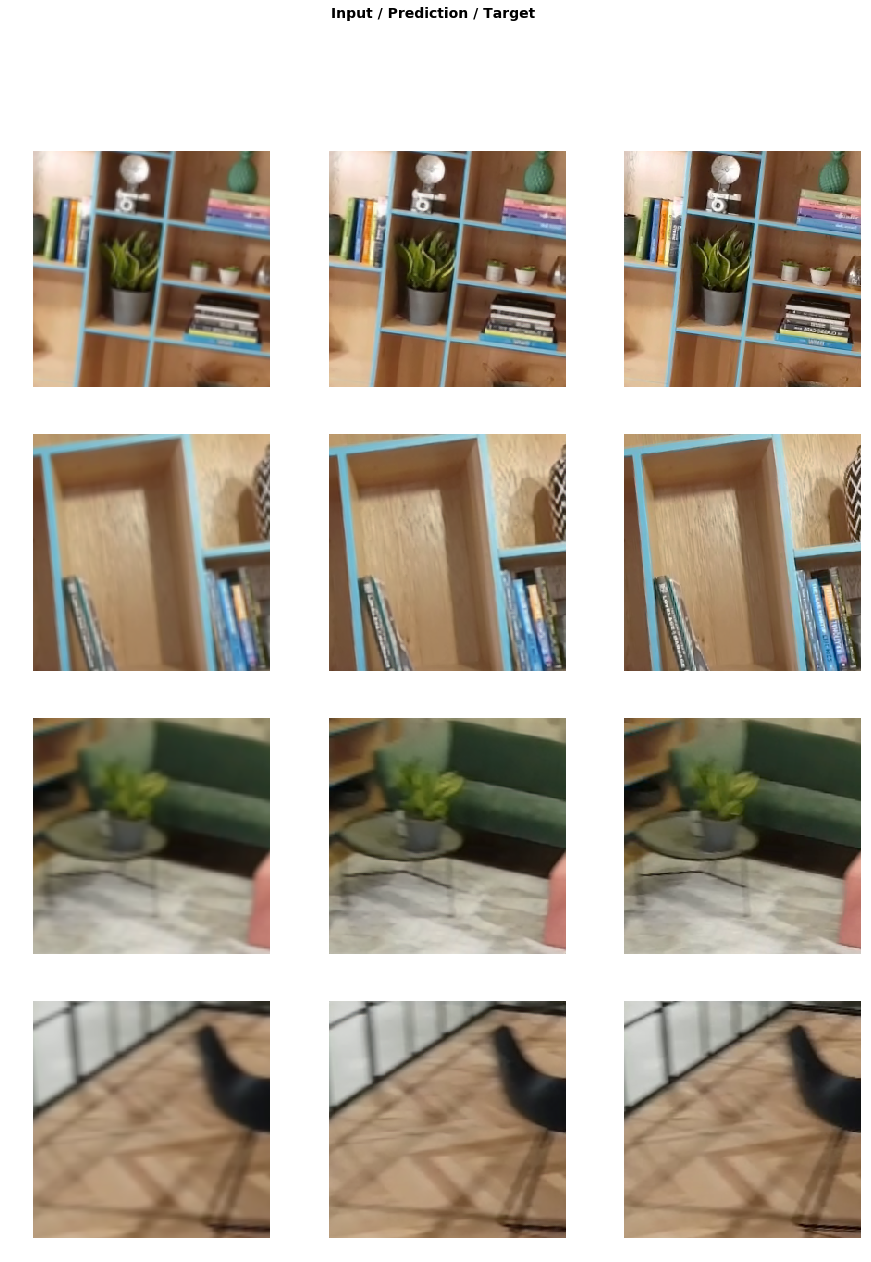

In [105]:
model_name = 'enhance-video' 
learn.save(model_name)
learn.show_results(ds_type= DatasetType.Train, rows=4, imgsize=5)

In [106]:
# learn.fit_one_cycle(10, slice(1e-6,lr))
# learn.save('superres-overfit-1b')
# learn.show_results(ds_type= DatasetType.Train, rows=4, imgsize=5)

In [107]:
# learn.fit_one_cycle(10, slice(1e-6,lr/100))
# learn.save('superres-overfit-1c')
# learn.show_results(ds_type= DatasetType.Train, rows=4, imgsize=5)

# Apply the network on one image and compare

In [110]:
idx_img = random.randint(0, len(il))
idx_img

1003

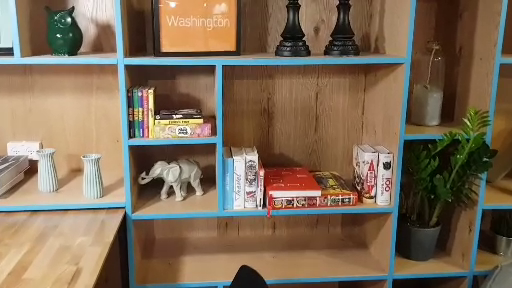

In [111]:
test_img = open_image(il.items[idx_img])
test_img

In [112]:
test_img.shape

torch.Size([3, 288, 512])

In [113]:
def round_up_to_even(f): 
    return math.ceil(f / 2.) * 2

rounded_up_size = round_up_to_even(test_img.shape[1]), round_up_to_even(test_img.shape[2])
new_size = rounded_up_size[0], rounded_up_size[1]
new_size

(288, 512)

In [114]:
path_test = path_images
data_test = (ImageImageList.from_folder(path_test).no_split()
          .label_from_func(lambda x: path_test/x.name)
          .transform(get_transforms(do_flip=False), size=new_size, tfm_y=True)
          .databunch(bs=2).normalize(imagenet_stats, do_y=True))
data_test.c = 3

In [115]:
learn = unet_learner(data_test, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)

In [116]:
def enhance_one(test_img):
    return learn.predict(test_img)[0]

In [117]:
folder = 'medres-144'
learn.load(path/f'{folder}/models/{model_name_pets}');
test_out_enh_pets = enhance_one(test_img)

learn.load(path/f'{folder}/models/{model_name}');
test_out_enh_vid = enhance_one(test_img)


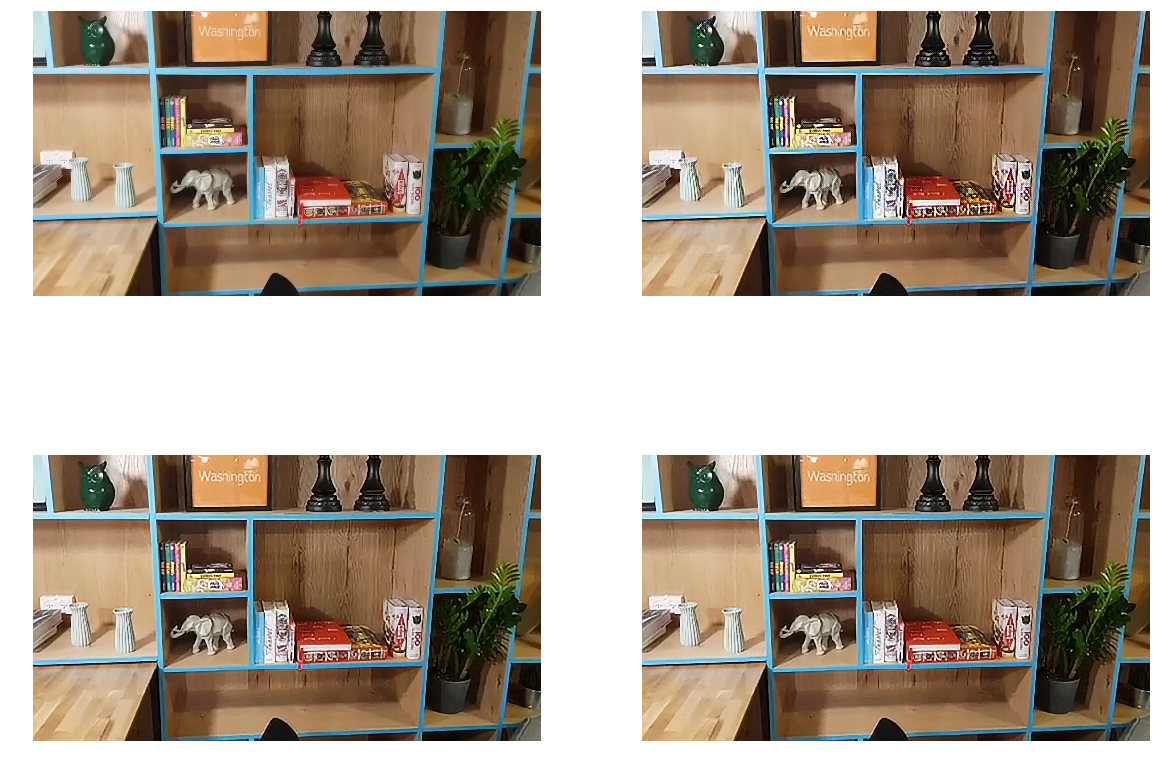

In [118]:
fig, ax = plt.subplots(2,2,figsize=(20,15))
test_img.show(ax[0,0])
test_out_enh_pets.show(ax[0,1])
test_out_enh_vid.show(ax[1,0])
test_out_enh_vid.show(ax[1,1])

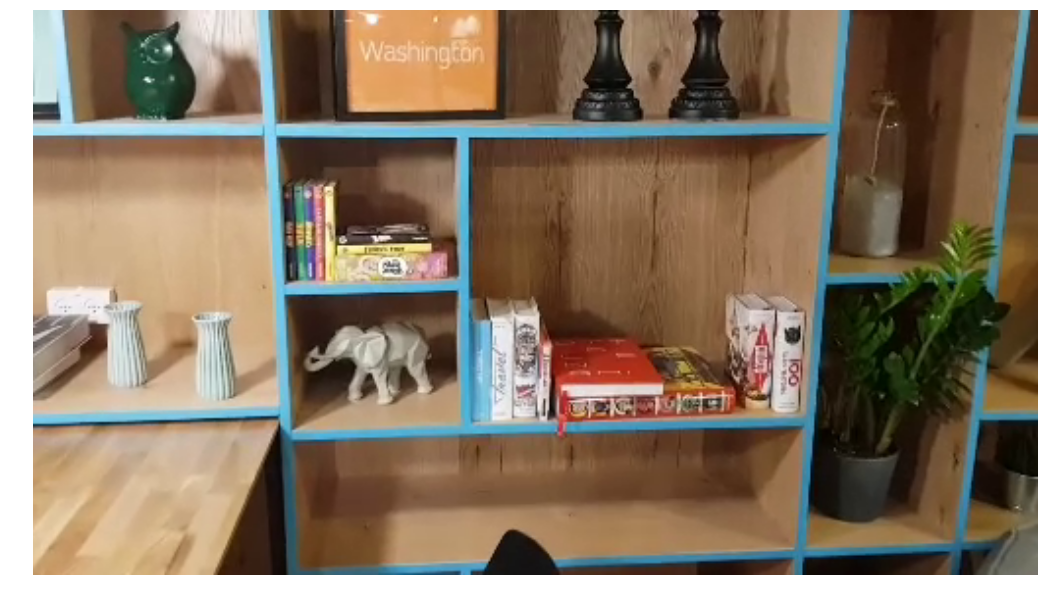

In [119]:
show_image(test_img, figsize=(18,15), interpolation='bilinear');

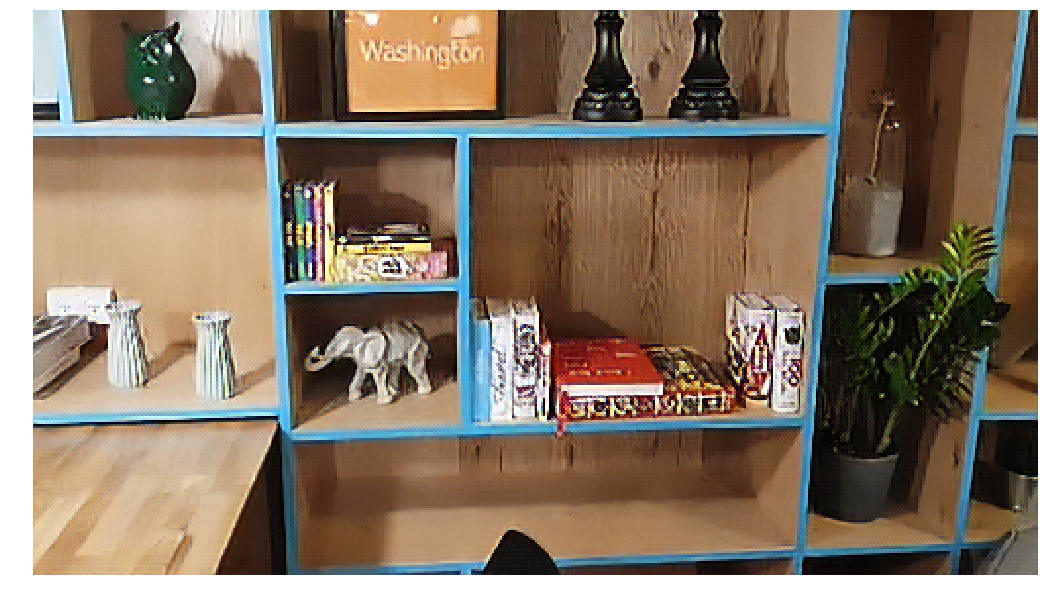

In [120]:
test_out_enh_pets.show(figsize=(18,15))

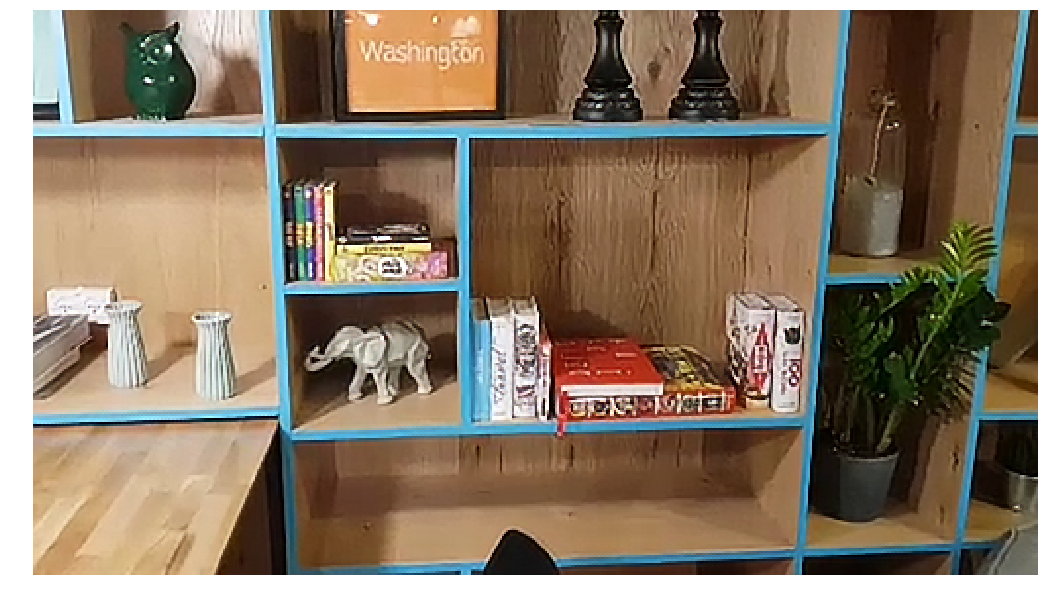

In [121]:
test_out_enh_vid.show(figsize=(18,15))

# Apply model on all the images

In [122]:
# torch.cuda.device("cpu")
# learn.num_workers = 1

In [130]:
learn.load(path/f'{folder}/models/{model_name}');
p=Path('vid-enh-test')

In [131]:
# preds, y = learn.get_preds(DatasetType.Train)

In [132]:
def apply_one(fn, i, path_out):
    dest = path_out/fn.relative_to(path_images)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = open_image(fn)
    enh_img = enhance_one(img)
    enh_img.save(dest)

In [133]:
apply_one(il.items[5],i=24, path_out=p)

In [134]:
from tqdm import tqdm
p=Path(name_output)
p.mkdir(exist_ok=True)
for fn in tqdm(il.items):
    apply_one(fn,0,p)

100%|██████████| 1636/1636 [04:36<00:00,  6.21it/s]


In [135]:
# p=Path('superres-mstn1')
# if not p.exists(): 
#     parallel(partial(apply_one, path_out=p), il.items)

In [136]:
# # create smaller image sets the first time this nb is run
# sets = [('path_lr', 72), (path_mr, 144)]
# for p,size in sets:
#     if not p.exists(): 
#         print(f"resizing to {size} into {p}")
#         parallel(partial(resize_one, path=p, size=size), il.items)

# Generate videos and compare them

In [137]:
def exec_cmd(cmd):
    print(f'cmd = {cmd}')
    log = subprocess.check_output(cmd, shell=True)
    return log

In [138]:
def create_output_video(folder_name, fps=video.fps):
    cmd = f'ffmpeg -framerate {str(fps)} -i {folder_name}/frame%03d.png -c:v libx264 {folder_name}.mp4'
    return exec_cmd(cmd)

In [139]:
# ! ffmpeg -framerate 30 -i input-images/frame%03d.png -c:v libx264 input-images.mp4

In [140]:
# # If needed, recreate the outputs from the ref and milestones
# create_output_video(name_ref)
# create_output_video(name_mstn1)

In [141]:
create_output_video(name_output)

cmd = ffmpeg -framerate 30.0 -i vid-enh-with-lse/frame%03d.png -c:v libx264 vid-enh-with-lse.mp4


b''

In [142]:
def merge_3_vid(name_vid1, name_vid2, name_vid3, name_comparison):
    cmd = f'ffmpeg -i {name_vid1}.mp4 -i {name_vid2}.mp4 -i {name_vid3}.mp4 -filter_complex vstack=inputs=3 {name_comparison}.mp4'
    print(f'cmd = {cmd}')
    log = subprocess.check_output(cmd, shell=True)
    return log

In [143]:
def merge_2_vid(name_vid1, name_vid2, name_comparison):
    cmd = f'ffmpeg -i {name_vid1}.mp4 -i {name_vid2}.mp4 -filter_complex vstack=inputs=2 {name_comparison}.mp4'
    print(f'cmd = {cmd}')
    log = subprocess.check_output(cmd, shell=True)
    return log

In [144]:
# ! ffmpeg -i vid-reg -i vid-superres-mstn2 -filter_complex vstack=inputs=2 vid-comparison.mp4

In [145]:
name_comparison = f'{name_output}_vs_{name_ref}'
merge_2_vid(name_output,name_ref, name_comparison)

cmd = ffmpeg -i vid-enh-with-lse.mp4 -i input-images.mp4 -filter_complex vstack=inputs=2 vid-enh-with-lse_vs_input-images.mp4


b''

In [148]:
name_comparison = f'{name_output}_vs_{name_mstn}_vs_{name_ref}'
merge_3_vid(name_output,name_mstn, name_ref, name_comparison)

cmd = ffmpeg -i vid-enh-with-lse.mp4 -i vid-enh-try1.mp4 -i input-images.mp4 -filter_complex vstack=inputs=3 vid-enh-with-lse_vs_vid-enh-try1_vs_input-images.mp4


b''

In [ ]:
# # Uncomment to display the comparison movie inside the notebook (but it makes it much heavier)
# VideoFileClip(name_comparison+'.mp4').ipython_display()